# Fast, Broadcasted Mueller Polarimetry

`katsu` was built in part to understand the spatially-varying polarized response of optics. Manufacturing errors can leave phase and amplitude aberrations in an optical beam, and understanding these sources of error is critical to understanding our system.

To spatially resolve this data, we need to be able to do full polarimetry on an array of pixels - so a naive implementation of the algorithm will take a very long time to run. Here, we show off the numpy optimizations done to speed up the polarimetric data reduction for Full Mueller Polarimetry.

Readers should first be familiar with the Full Mueller Polarimetry demo

_written by Jaren Ashcraft_

In [1]:
from katsu.polarimetry import full_mueller_polarimetry,broadcasted_full_mueller_polarimetry,broadcast_kron,broadcast_outer
from katsu.mueller import linear_polarizer,linear_retarder
import numpy as np
from time import perf_counter

Polarimetric data reduction boils down to matrix multiplications and Kronecker products. Numpy is already configured to broadcast matrix multiplications, just stuff the matrix dimensions into the final two axes of the numpy array! But `np.kron` is a more general operation that operates on tensors of arbritrary dimension. A naive implementation of looping over the broadcasted dimensions would look like the following:

In [2]:
array_of_matrices = np.random.random([128,128,2,2])
array_out_naive = np.zeros([128, 128, 4, 4])

t1 = perf_counter()
for i in range(array_of_matrices.shape[0]):
    for j in range(array_of_matrices.shape[1]):

        array_out_naive[i,j] = np.kron(array_of_matrices[i,j], array_of_matrices[i,j])

runtime_naive = perf_counter() - t1
print(runtime_naive,'s to compute naive kronecker')

0.44942269999999995 s to compute naive kronecker


This is perfectly acceptable, but may scale unfavorably for large datasets that are highly sampled. In contrast, the implementation in `katsu.polarimetry` has configured the kronecker product using `np.einsum`, which batches the computation in the broadcast dimensions. 

In [3]:
array_out = np.zeros([128, 128, 4, 4])

t1 = perf_counter()
array_out = broadcast_kron(array_of_matrices, array_of_matrices)
runtime_broadcast = perf_counter() - t1
print(runtime_broadcast,'s to compute broadcast kronecker')
print(runtime_naive / runtime_broadcast,'x relative speedup from naive implementation')

0.002758200000000155 s to compute broadcast kronecker
162.940577188012 x relative speedup from naive implementation


Just by virtue of a more specialized implementation, we can achieve runtime increases two orders of magnitude greater than the looped case. Furthermore, the results are functionally identical. Below we plot the difference of the elements of the matrix as a function of the first two array dimensions and observe that the results are entirely zero.

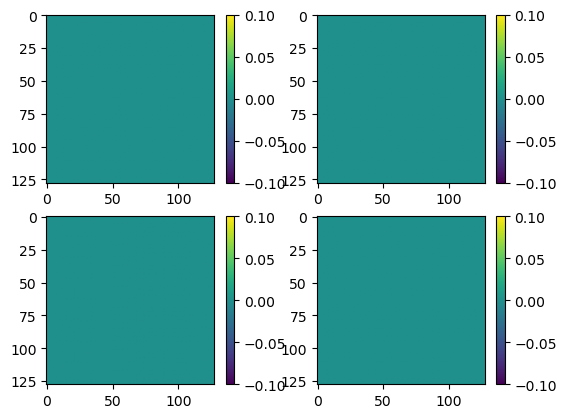

In [5]:
import matplotlib.pyplot as plt
difference = (array_out_naive - array_out) 
k = 1
plt.figure()
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,k)
        plt.imshow(difference[..., i, j])
        plt.colorbar()
        k += 1
plt.show()

This is a no-compromise method of doing broadcasted kronecker products for Mueller matrices, and is our default for Mueller polarimetry in `katsu`, which we demonstrate below

In [17]:
starting_angles={'psg_polarizer':0,
                'psg_qwp':0,
                'psa_qwp':0,
                'psa_polarizer':0}
nmeas = 26
thetas = np.linspace(0,2*np.pi,nmeas)

# Generate an array of random
Min = linear_polarizer(np.random.random()) @ linear_retarder(np.random.random(),np.random.random())

Mg = linear_retarder(starting_angles['psg_qwp']+thetas,np.pi/2) @ linear_polarizer(starting_angles['psg_polarizer'])
Ma = linear_polarizer(starting_angles['psa_polarizer']) @ linear_retarder(starting_angles['psa_qwp']+thetas*5,np.pi/2)
PSA = Ma[...,0,:]
PSA = PSA[...,np.newaxis]
PSA.shape

PSG = Mg[...,:,0]
PSG = PSG[..., np.newaxis]
PSG.shape

Wmat = broadcast_kron(PSA,PSG).reshape([nmeas,16])
Wmat.shape
Min = np.broadcast_to(Min,[*PSA.shape[:-2],4,4])
Min.shape
Pmat = (np.swapaxes(PSA,-1,-2) @ Min @ PSG) 
M_meas = np.linalg.pinv(Wmat) @ Pmat[...,0,0]

In [20]:
print(Min[0])
print(Min[0] - M_meas.reshape([4,4]))

[[ 0.5         0.00623738  0.48528769 -0.12023706]
 [ 0.0695999   0.00086824  0.06755195 -0.01673698]
 [ 0.49513216  0.00617666  0.48056308 -0.11906647]
 [ 0.          0.          0.          0.        ]]
[[ 0.00000000e+00 -1.11022302e-16  2.22044605e-16  1.11022302e-16]
 [-3.46944695e-16  3.33934269e-16  3.33066907e-16  0.00000000e+00]
 [ 3.33066907e-16  3.05311332e-16  1.11022302e-16  2.49800181e-16]
 [ 1.38777878e-17 -8.32667268e-17  2.22044605e-16 -6.24500451e-17]]


AttributeError: 'int' object has no attribute 'shape'